In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=50
args.lr = 1e-3
args.batch_size= 128
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=10,length=20"
args.hidden_dims = [15,15]
args.save_model = ""
args.dataset = "Dialysis"


In [4]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [5]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [6]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([5444, 74])

In [7]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(RightCensorWrapper(clf_robust),dataset_train.tensors)
model_fragile_wrap = BoundedModule(RightCensorWrapper(clf_fragile),dataset_train.tensors)

In [8]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1980.6995 Time=0.0030
[ 1:  10]: eps=0.00000000 Loss=1871.4553 Time=0.0024
[ 1:  20]: eps=0.00000000 Loss=1838.7120 Time=0.0023
[ 1:  30]: eps=0.00000000 Loss=1784.1769 Time=0.0023
[ 1:  40]: eps=0.00000000 Loss=1732.7612 Time=0.0023
[ 1:  42]: eps=0.00000000 Loss=1714.7019 Time=0.0022
Epoch time: 0.1233, Total time: 0.1233
Evaluating...
[ 1:  10]: eps=0.00000000 Loss=1421.7431 Time=0.0012
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1428.5410 Time=0.0020
[ 2:  10]: eps=0.00000000 Loss=1384.7410 Time=0.0022
[ 2:  20]: eps=0.00000000 Loss=1321.4147 Time=0.0022
[ 2:  30]: eps=0.00000000 Loss=1248.5601 Time=0.0022
[ 2:  40]: eps=0.00000000 Loss=1183.6212 Time=0.0022
[ 2:  42]: eps=0.00000000 Loss=1166.5871 Time=0.0022
Epoch time: 0.1229, Total time: 0.2462
Evaluating...
[ 2:  10]: eps=0.00000000 Loss=774.7076 Time=0.0011
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=863.6652 Time=0.0020
[ 3:  10

In [9]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1980.6995 Time=0.0030
[ 1:  10]: eps=0.00000000 Loss=1871.4553 Time=0.0030
[ 1:  20]: eps=0.00000000 Loss=1838.7120 Time=0.0031
[ 1:  30]: eps=0.00000000 Loss=1784.1769 Time=0.0029
[ 1:  40]: eps=0.00000000 Loss=1732.7612 Time=0.0028
[ 1:  42]: eps=0.00000000 Loss=1714.7019 Time=0.0028
Epoch time: 0.1497, Total time: 0.1497
Evaluating...
[ 1:  10]: eps=0.00000000 Loss=1421.7431 Time=0.0014
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1428.5410 Time=0.0020
[ 2:  10]: eps=0.00000000 Loss=1384.7410 Time=0.0024
[ 2:  20]: eps=0.00000000 Loss=1321.4147 Time=0.0026
[ 2:  30]: eps=0.00000000 Loss=1248.5601 Time=0.0026
[ 2:  40]: eps=0.00000000 Loss=1183.6212 Time=0.0026
[ 2:  42]: eps=0.00000000 Loss=1166.5871 Time=0.0025
Epoch time: 0.1373, Total time: 0.2870
Evaluating...
[ 2:  10]: eps=0.00000000 Loss=774.7076 Time=0.0015
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=863.6652 Time=0.0020
[ 3:  10

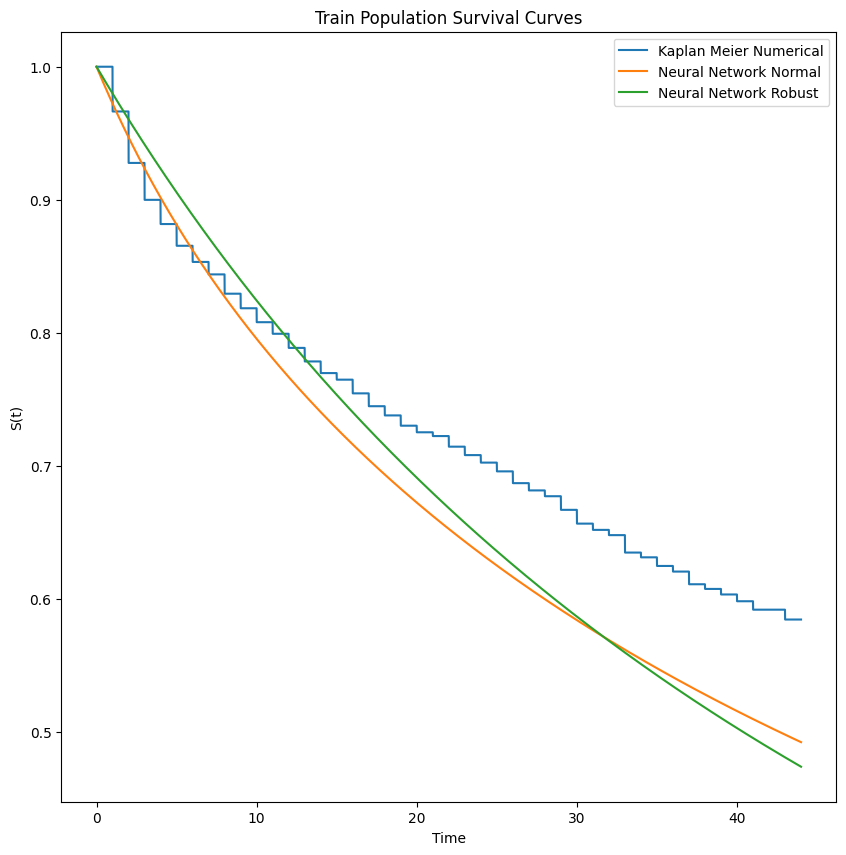

In [10]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_fragile_x.mean(0))
plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.show()

<Figure size 1000x1000 with 0 Axes>

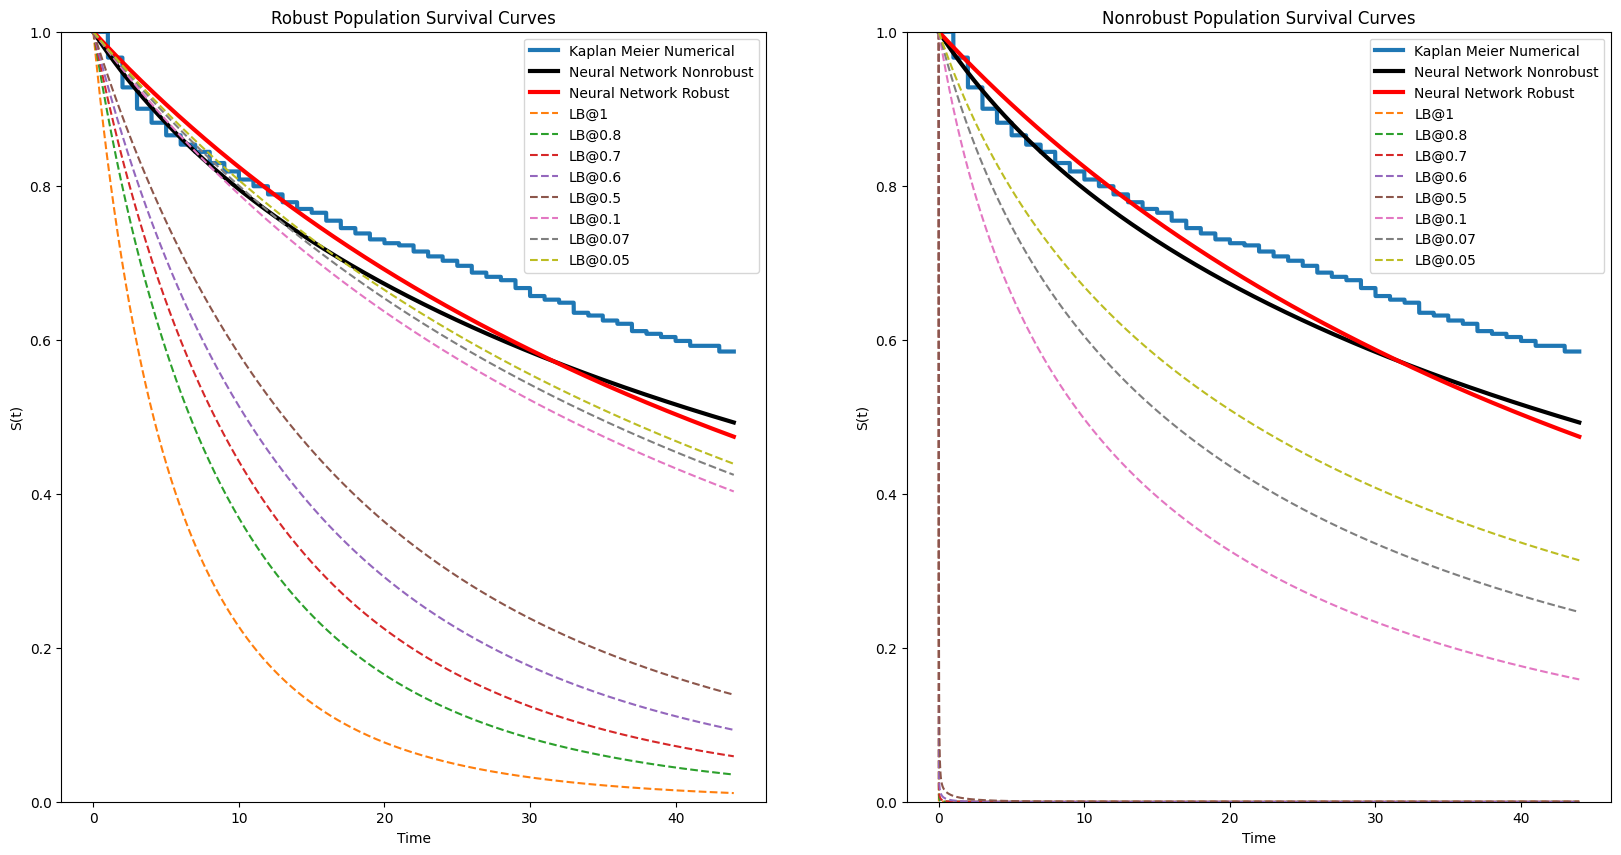

In [11]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)

<Figure size 1000x1000 with 0 Axes>

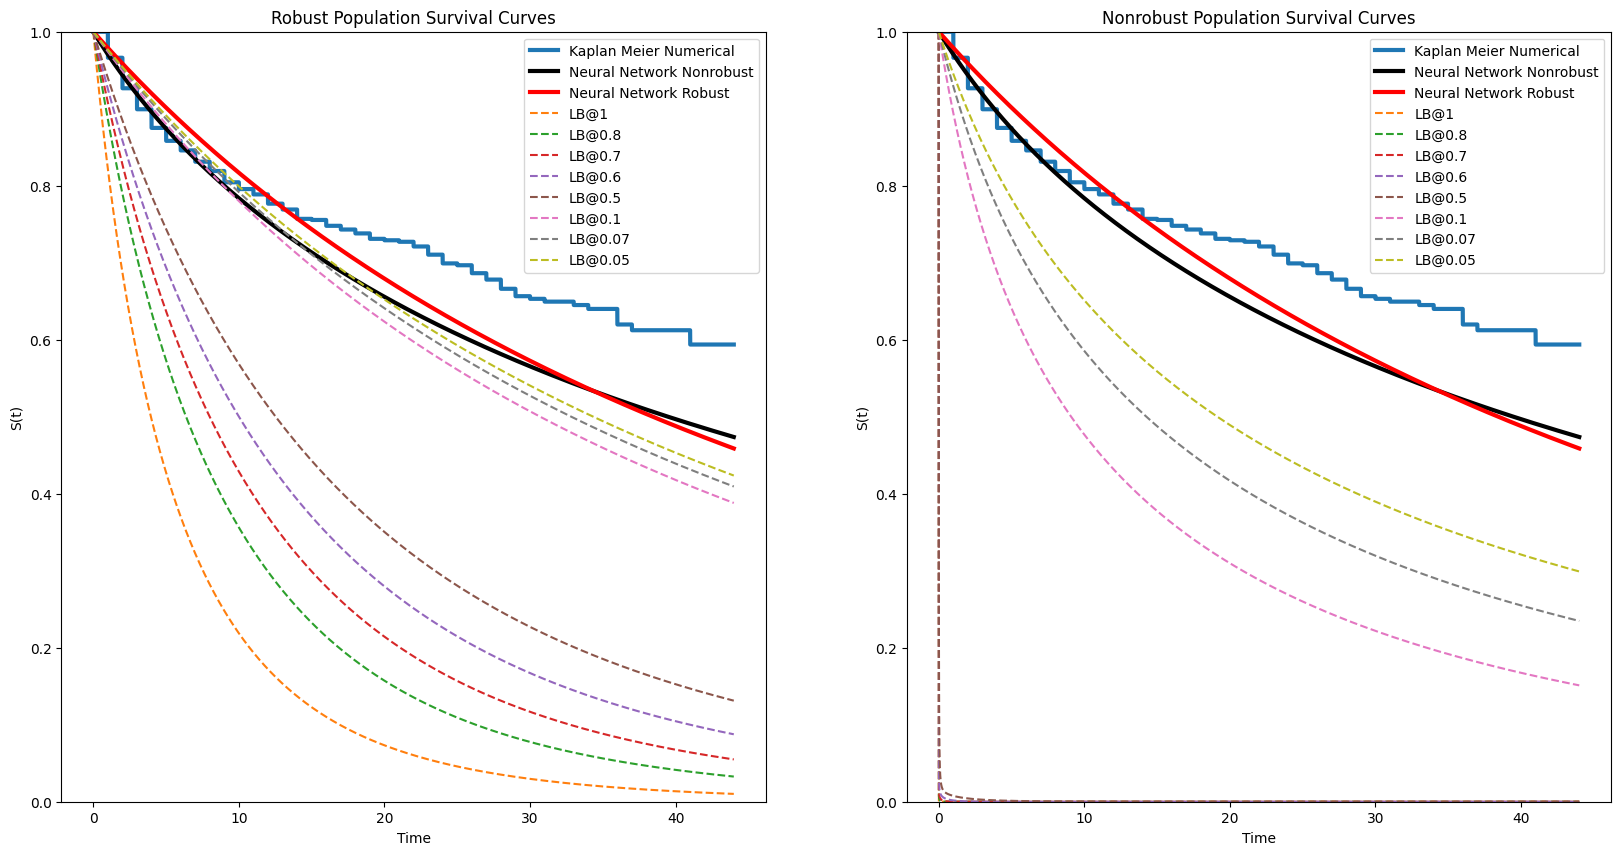

In [12]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

tensor([5.2208, 5.4883, 5.7446, 5.9426, 6.0093, 6.0813, 6.4655, 6.4886, 6.5717,
        6.6992])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


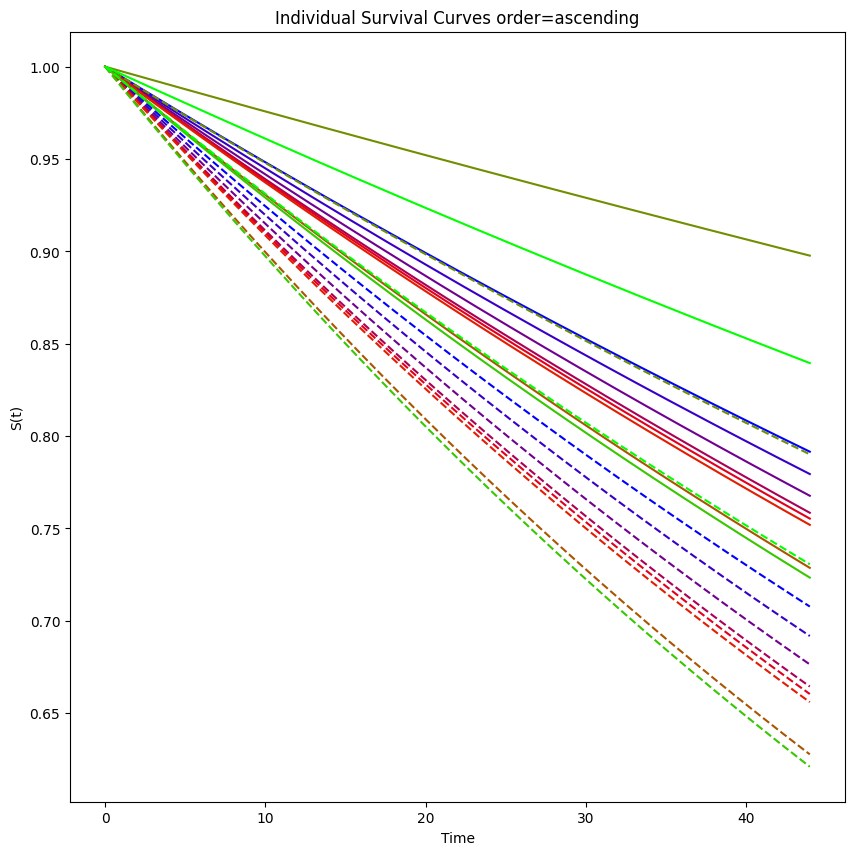

In [13]:
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=0.3,order="ascending")

tensor([28.7020, 28.6012, 28.5755, 28.4975, 28.3825, 27.5368, 27.3702, 27.3678,
        27.3665, 27.3642])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


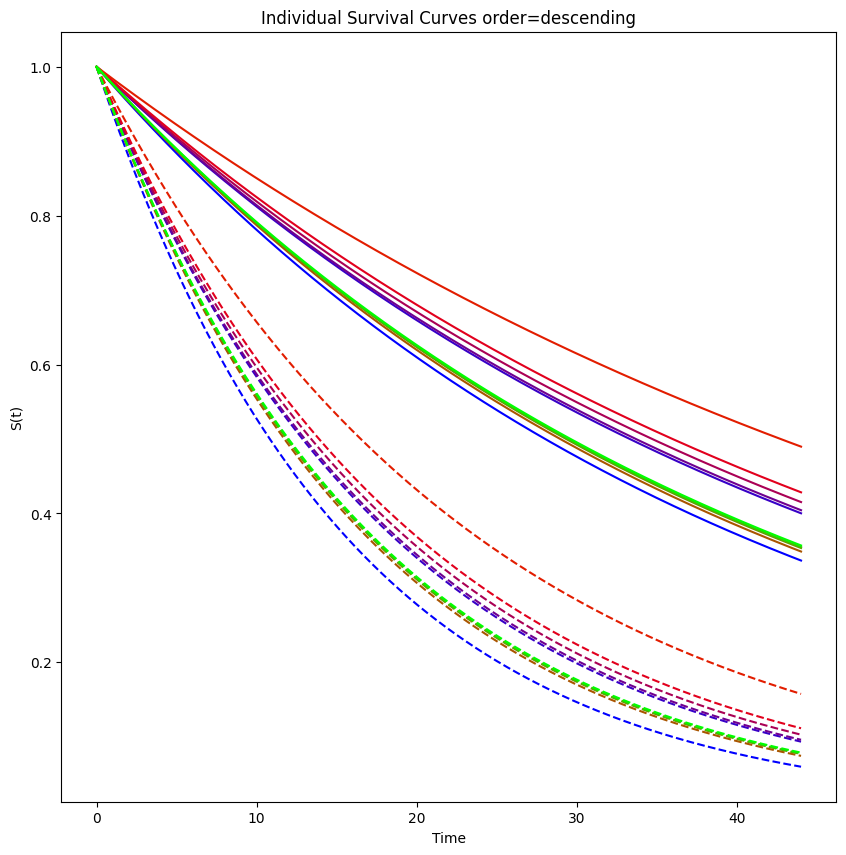

In [14]:
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=0.3,order="descending")

tensor([7.1290, 7.3096, 7.5811, 7.7864, 7.9832, 8.0935, 8.1905, 8.2591, 8.3555,
        8.3857])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]


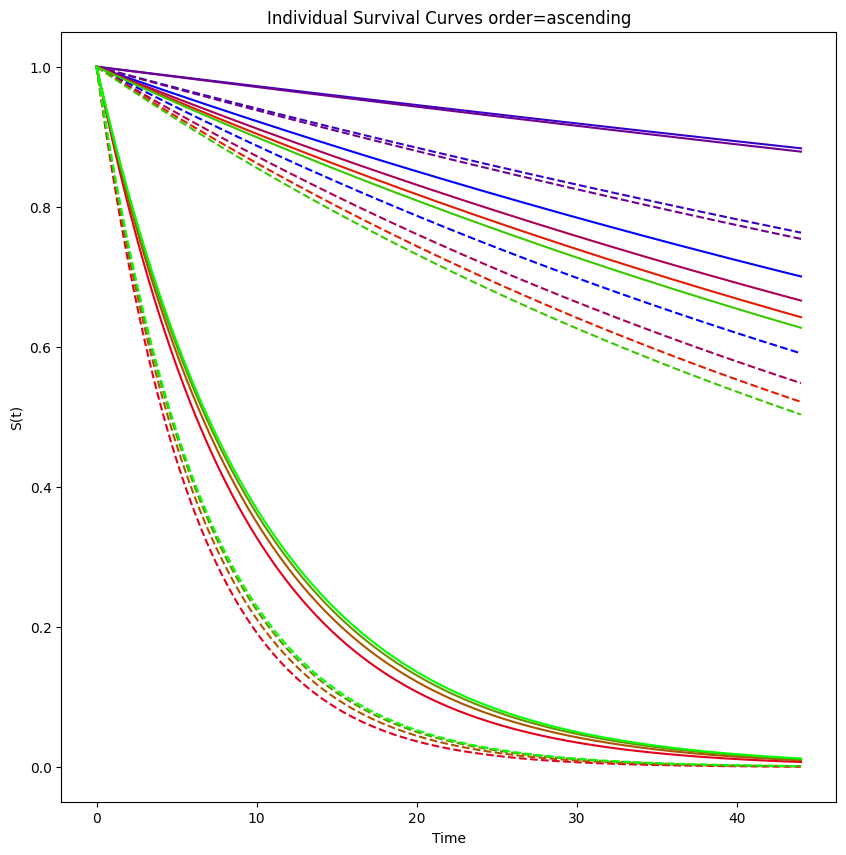

In [15]:
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=0.3,order="ascending")

tensor([28.7124, 28.2704, 27.3699, 27.2938, 27.2865, 27.2006, 27.1939, 27.1925,
        27.1778, 27.1684])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.96it/s]


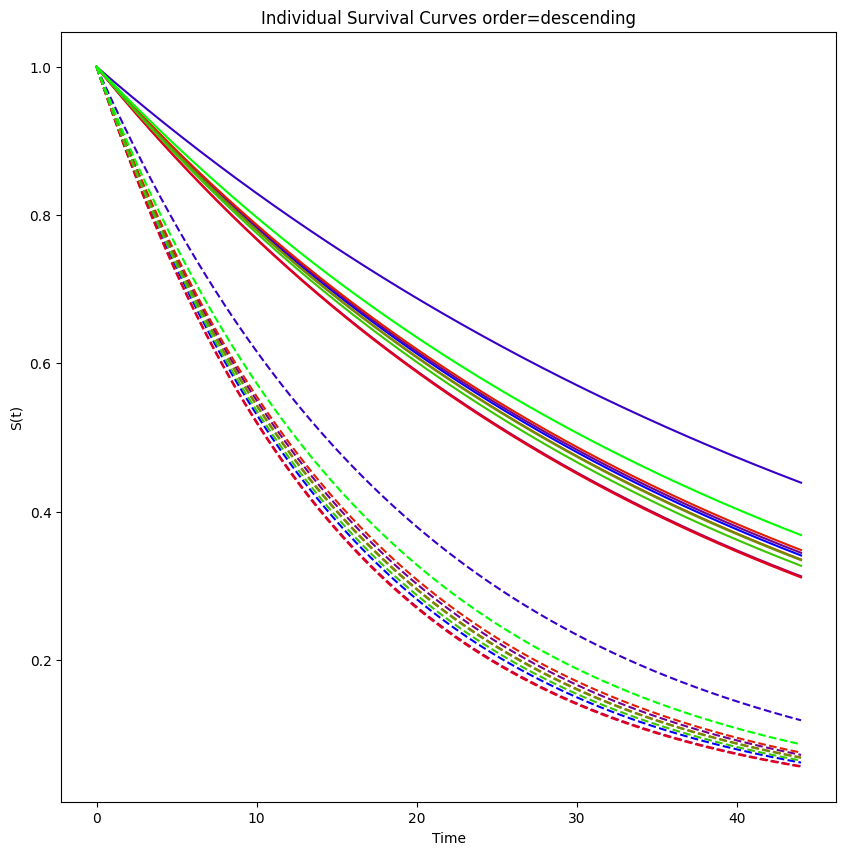

In [16]:
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=0.3,order="descending")